<a href="https://colab.research.google.com/github/DenisDrobyshev/university/blob/master/%D0%A3%D0%9F%D0%98%D0%A1_%D0%97%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%E2%84%964_%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B1%D0%B0%D0%B7%D1%8B_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85_%D0%B4%D0%BB%D1%8F_%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%BE%D0%B9_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Задание №4. Проектирование базы данных для информационной системы**

## **Введение**

База данных является фундаментом любой информационной системы, обеспечивая надежное хранение, эффективный доступ и целостность данных. В контексте управления проектами создания информационных систем грамотное проектирование базы данных критически важно для успеха всего проекта, поскольку ошибки на этом этапе могут привести к серьезным проблемам производительности, масштабируемости и поддержки системы в будущем.

## **Формулировка задания**

На основе ранее разработанных концептуальных основ проекта, иерархической структуры работ и UML-диаграмм, спроектируйте реляционную базу данных для вашей информационной системы. Результатом работы должна стать ER-диаграмма (Entity-Relationship Diagram), отражающая структуру данных, необходимых для функционирования вашего проекта.

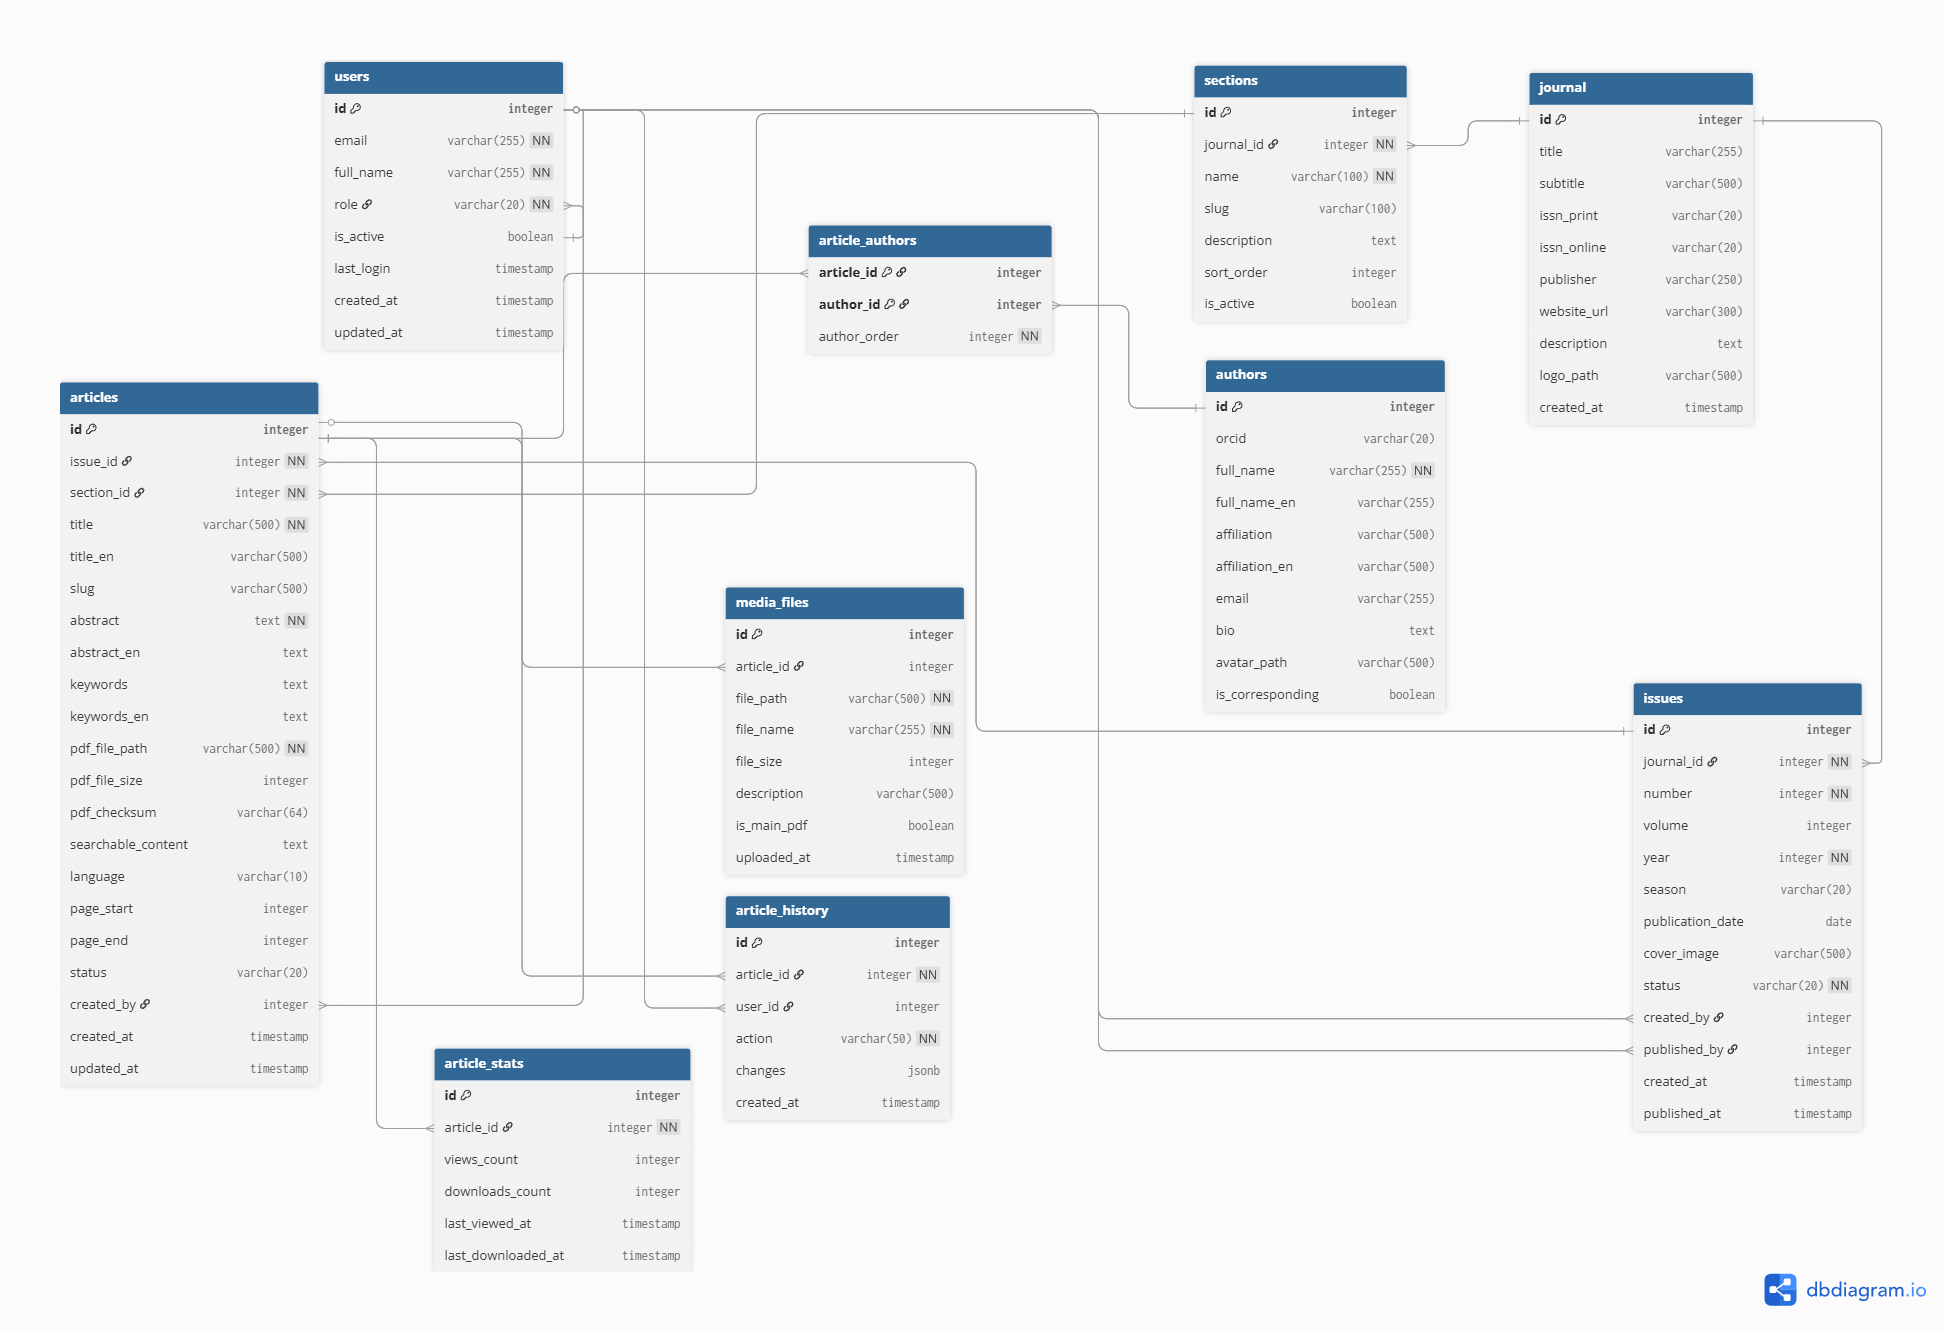

База данных состоит из 10 связанных таблиц, которые полностью (на данный момент согласования проекта) покрывают нужды системы: управление пользователями, выпусками, статьями, авторами, файлами, сбор статистики и отслеживание изменений.

Таблица users — здесь вся информация о пользователях системы: читателях, редакторах и админах. Уровень доступа определяется полем role. Если нужно заблокировать пользователя, используйте is_active, чтобы не удалять его профиль.

Таблица journal — это данные о журнале: название, ISSN (печатный и электронный), издатель. Можно добавить логотип и описание.

Таблица sections — тут рубрики по темам («Геодезия», «ДЗЗ», «Навигация»). Они нужны для поиска и навигации по сайту. slug нужен для SEO.

Таблица issues — это выпуски журнала с годом, номером, датой публикации и статусом (DRAFT, PUBLISHED). Есть поля для DOI-префикса и ссылок на редакторов (created_by, published_by).

Таблица articles — главная таблица. В ней:

*   метаданные на двух языках (title, abstract, keywords на русском и английском),
*   DOI, УДК, номера страниц,
*   путь к PDF-файлу и хеш для проверки,
*   searchable_content — полный текст для поиска,
*   статус публикации.

Таблица authors — информация об авторах: ORCID, аффилиации на двух языках, email и биография. Это поможет интегрироваться с разными международными базами.

Таблица article_authors — связывает авторов со статьями, показывает порядок авторов (author\_order).

Таблица media\_files — сюда можно добавлять не только PDF, но и датасеты, код, картинки.

Таблица article\_stats — здесь собирается статистика по просмотрам и скачиваниям. Это разгружает основную таблицу articles.

Таблица article\_history — в этой таблице записываются все изменения: кто, когда и что поменял. Это нужно, чтобы можно было всё вернуть назад и видеть, кто что делал.


Обоснование структуры бд

Нормализация
1) Данные не повторяются (авторы, рубрики, пользователи хранятся в отдельных таблицах).
2) Нет лишних зависимостей.
3) Связи многие ко многим (many to many) (например, авторы) реализованы через отдельные таблицы.

Масштабируемость
1) Поддержка DOI и ORCID позволит работать с международными системами (Crossref, ORCID API).
2) Таблица media_files упрощает добавление новых типов файлов.
3) Статистика хранится отдельно, что не замедляет основные операции.

Безопасность и надёжность
1) Хеширование PDF (pdf_checksum) нужно для проверки целостности файлов.
2) История изменений (article_history) позволяет отслеживать все правки.
3) Роли пользователей (users.role) ограничивают доступ к функциям.

Соответствие требованиям (!)
1) Двуязычные метаданные — это требования РИНЦ и Scopus.
2) УДК и DOI — общепринятые стандарты для научных публикаций. (нужны ли?)
3) ЧПУ (slug) важны для поисковой оптимизации.


In [ ]:
'''Поиск статей по ключевым словам и году'''

SELECT
    a.title,
    a.abstract,
    i.year,
    s.name AS section,
    STRING_AGG(auth.full_name, ', ') AS authors
FROM articles a
JOIN issues i ON a.issue_id = i.id
JOIN sections s ON a.section_id = s.id
JOIN article_authors aa ON a.id = aa.article_id
JOIN authors auth ON aa.author_id = auth.id
WHERE
    i.year = 2024
    AND (
        a.keywords ILIKE '%геодезия%'
        OR a.searchable_content ILIKE '%геодезия%'
        OR a.keywords_en ILIKE '%geodesy%'
    )
    AND a.status = 'PUBLISHED'
GROUP BY a.id, i.year, s.name
ORDER BY i.year DESC, a.created_at DESC;

In [ ]:
'''Получение полной информации о статье'''

SELECT
    a.title,
    a.abstract,
    a.doi,
    a.udc,
    a.pdf_file_path,
    i.year,
    i.number AS issue_number,
    j.title AS journal_title,
    STRING_AGG(
        CONCAT(auth.full_name, ' (', auth.affiliation, ')'),
        '; '
    ) AS authors_with_affiliations
FROM articles a
JOIN issues i ON a.issue_id = i.id
JOIN journal j ON i.journal_id = j.id
JOIN article_authors aa ON a.id = aa.article_id
JOIN authors auth ON aa.author_id = auth.id
WHERE a.slug = 'geodeziya-metod-2024'
  AND a.status = 'PUBLISHED'
GROUP BY a.id, i.id, j.id;

In [ ]:
'''Статистика по популярности рубрик за год'''

SELECT
    s.name AS section,
    COUNT(a.id) AS article_count,
    SUM(stats.views_count) AS total_views
FROM sections s
JOIN articles a ON s.id = a.section_id
JOIN article_stats stats ON a.id = stats.article_id
JOIN issues i ON a.issue_id = i.id
WHERE i.year = 2024
  AND a.status = 'PUBLISHED'
GROUP BY s.id
ORDER BY total_views DESC;

In [ ]:
'''Аудит изменений статьи'''

SELECT
    u.full_name AS editor,
    h.action,
    h.changes,
    h.created_at
FROM article_history h
JOIN users u ON h.user_id = u.id
WHERE h.article_id = 123
ORDER BY h.created_at DESC;